In [1]:
class TaskController:
    def __init__(self, env, learning_algorithm='SARSA', exploration=True, exploration_decay='SIMULATED_ANNEALING', 
                 exploration_strategy='E_GREEDY', exploration_epsilon=0.8, 
                 learning_rate=0.01, learning_rate_decay='EXPONENTIAL', gamma=0.9, online_learning=False,
                 *args, **kwargs):
        self.env = env
        policy = Policy(self.env, states=self.env.all_states(), actions=self.env.all_actions(),
                        state_action_validity_checker=self.env.is_state_action_pair_valid, 
                        algorithm=learning_algorithm, exploration=exploration, exploration_decay=exploration_decay, 
                        exploration_strategy=exploration_strategy, exploration_epsilon=exploration_epsilon, 
                        learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, gamma=gamma)
        self.agent = Agent(policy, initial_state=self.env.get_initial_state())
        self.online_learning = online_learning
        
    def run_episode(self, learning_phase=True):
        
        action = self.agent.choose_action(self.agent.current_state, always_greedy=not learning_phase)
        
        self.agent.next_state, reward = self.env.get_next_state_reward(self.agent.current_state, action)
        if learning_phase:
            if self.online_learning:
                next_action = None
                if self.agent.policy.algorithm_type == 'SARSA':
                    next_action = self.agent.choose_action(self.agent.next_state, always_greedy=True)
                elif self.agent.policy.algorithm_type == 'QLEARNING':
                    next_action = None
                else:
                    # EXPECTED_SARSA all actions are averaged
                    next_action = None
                self.agent.feed_reward(reward, self.agent.current_state, self.agent.next_state, 
                                              action, next_action)
            else:
                self.agent.policy.history.append({'state': self.agent.current_state, 'action': action, 'reward': reward})
                #print(self.agent.policy.history)
        else:
            self.agent.policy.history.append({'state': self.agent.current_state, 'action': action, 'reward': reward})
                
        if self.env.is_terminal(self.agent.next_state):
            self.env.episode_terminated = True
            if not self.online_learning and learning_phase:
                self.agent.feed_reward(reward, self.agent.current_state, self.agent.next_state,
                                                  None, None, online=False)
                self.agent.reset_history()
            
        self.agent.cur-rent_state = self.agent.next_state
        
        return self.agent.current_state, action, self.agent.next_state, reward
    
    def reset(self):
        self.env.episode_terminated = False
        self.agent.current_state=(NUM_ROWS-1,0)

In [2]:
import numpy as np
from numpy.random import random, choice

class Policy:
    def __init__(self, env, states={}, actions={}, state_action_validity_checker=None, 
                 hash_states=False, hash_actions=False,
                 algorithm='QLEARNING', exploration=True, exploration_decay='SIMULATED_ANNEALING', 
                 exploration_strategy='E_GREEDY', exploration_epsilon=0.8, 
                 learning_rate=0.01, learning_rate_decay='EXPONENTIAL', gamma=0.9, *args, **kwargs):
        # Set the update rule
        self.env = env
        self.algorithm_type = algorithm
        
        if algorithm=='QLEARNING':
            self.algorithm = QLearning(learning_rate=learning_rate,
                                       gamma=gamma, *args, **kwargs)
        elif algorithm=='SARSA':
            self.algorithm = Sarsa(learning_rate=learning_rate, 
                                   gamma=gamma,*args, **kwargs)
        elif algorithm=='EXPECTED_SARSA':
            self.algorithm = ExpectedSarsa(learning_rate=learning_rate, 
                                           gamma=gamma,*args, **kwargs)
        elif algorithm=='EVERY_VISIT_MC':
            self.algorithm = EveryVisitMC(*args, **kwargs)
        elif algorithm=='FIRST_VISIT_MC':
            self.algorithm = FirstVisitMC(*args, **kwargs)
        else:
            self.algorithm = QLearning(learning_rate=learning_rate,
                                       gamma=gamma, *args, **kwargs)
           
        # Set exploration-exploitation strategy
        self.exploration = exploration
        if self.exploration:
            self.exploration_decay = exploration_decay
            self.exploration_strategy = exploration_strategy
            self.exploration_epsilon = exploration_epsilon
            
        # Set LR and gamma
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        
        self.gamma = gamma
        
        # Initialize policy
        self.states = [hash(state) for state in states] if hash_states else states
        
        self.hash_states = hash_states
        self.hash_actions = hash_actions
        
        self.policy = dict()
        actions = list(actions)
        for state in self.states:
            temp = dict()
            for action in actions:
                if state_action_validity_checker(state, action):
                    temp[action] = 0.1
            self.policy[state] = temp
        
        self.history = []
    
    def feed_reward(self, reward, current_state, next_state, current_action, next_action, online=True):
        if online:
            self.algorithm.feed_reward(self, reward=reward, 
                                       current_state=current_state, 
                                       next_state=next_state, 
                                       current_action=current_action, 
                                       next_action=next_action)
        else:
            # Offline episodic updates
            # History is an array of dicts [{'state': state, 'action': action},{...},...]
            last_element = True
            
            for elm in reversed(self.history):
                reward = elm['reward']
                if last_element:
                    last_element = False
                    next_state = elm['state']
                    next_action = elm['action']
                current_state = elm['state']
                current_action = elm['action']
                self.algorithm.feed_reward(self, reward=reward, 
                                           current_state=current_state, 
                                           next_state=next_state, 
                                           current_action=current_action, 
                                           next_action=next_action)
                next_state = current_state
                next_action = current_action
                
            if self.algorithm_type in ['EVERY_VISIT_MC', 'FIRST_VISIT_MC']:
                for state, temp in self.algorithm.visit_count.items():
                    for action, value in temp.items():
                        self.policy[state][action] = (self.policy[state][action]*(self.algorithm.num_iter) 
                                                      + np.mean(self.algorithm.visit_count[state][action]))/(self.algorithm.num_iter+1)
                self.algorithm.reset_episode()
            
        return reward
    
    def choose_action(self, state, always_greedy=False):
        action = None
        if always_greedy:
            return max(self.policy[state], key=self.policy[state].get)
        if self.exploration:
            # Learning Phase
            if random() > self.exploration_epsilon:
                # Exploitation
                action = max(self.policy[state], key=self.policy[state].get)
            else:
                # Exploration
                if self.exploration_strategy == 'E_GREEDY':
                    min_v = min(self.policy[state].values())
                    non_neg_v = [v - min_v + 0.1 for v in self.policy[state].values()]
                    total = sum(non_neg_v)
                    ordered_actions = [(k,float(v - min_v + 0.1)/total) for k,v in self.policy[state].items()]
                    a = [a[0] for a in ordered_actions]
                    p = [a[1] for a in ordered_actions]
                    action = choice(a, p=p)
                else:
                    action = choice(list(self.policy[state].keys()))
                
                # Decay of exploration rate
                if self.exploration_decay=='SIMULATED_ANNEALING':
                    self.exploration_epsilon = self.exploration_epsilon*0.99
                elif self.exploration_decay=='CONSTANT':
                    self.exploration_epsilon = self.exploration_epsilon
        
        else:
            # Non Learning Phase
            action = max(self.policy[state], key=self.policy[state].get)
        
        return action
    
    
class Sarsa:
    # Use >300 episodes
    def __init__(self, learning_rate=0.01, gamma=0.9, eligibility_trace=False):
        self.LR = learning_rate
        self.GAMMA = gamma
        self.num_iter = 0
    
    def feed_reward(self, policy, reward=None, current_state=None, next_state=None, current_action=None, next_action=None):
        # Python is pass by name and mutability of object decides whether it acts as pass by value or reference
        # Dicts are mutable and therefore this modifies the self.policy on Policy instance
        policy.policy[current_state][current_action] = policy.policy[current_state][current_action] + self.LR*(
            reward + self.GAMMA*policy.policy[next_state][next_action] - policy.policy[current_state][current_action])
        
        # Learning rate decay (logarithmic)
        self.num_iter += 1
        self.LR = min(1.0/np.log(self.num_iter), self.LR)
        return self.num_iter
    
class QLearning:
    # Use >300 episodes
    def __init__(self, learning_rate=0.01, gamma=0.9, eligibility_trace=False):
        self.LR = learning_rate
        self.GAMMA = gamma
        self.num_iter = 0
    
    def feed_reward(self, policy, reward=None, current_state=None, next_state=None, current_action=None, next_action=None):
        # Python is pass by name and mutability of object decides whether it acts as pass by value or reference
        # Dicts are mutable and therefore this modifies the self.policy on Policy instance
        policy.policy[current_state][current_action] = policy.policy[current_state][current_action] + self.LR*(
            reward + self.GAMMA*max(policy.policy[next_state].values()) - policy.policy[current_state][current_action])
        
        # Learning rate decay (logarithmic)
        self.num_iter += 1
        self.LR = min(1.0/np.log(self.num_iter), self.LR)
        return self.num_iter
    
class ExpectedSarsa:
    # Use >1000 episodes
    def __init__(self, learning_rate=0.01, gamma=0.9, eligibility_trace=False):
        self.LR = learning_rate
        self.GAMMA = gamma
        self.num_iter = 0
    
    def feed_reward(self, policy, reward=None, current_state=None, next_state=None, current_action=None, next_action=None):
        # Python is pass by name and mutability of object decides whether it acts as pass by value or reference
        # Dicts are mutable and therefore this modifies the self.policy on Policy instance
        policy.policy[current_state][current_action] = policy.policy[current_state][current_action] + self.LR*(
            reward + self.GAMMA*np.mean(list(policy.policy[next_state].values())) - policy.policy[current_state][current_action])
        
        # Learning rate decay (logarithmic)
        self.num_iter += 1
        self.LR = min(1.0/np.log(self.num_iter), self.LR)
        return self.num_iter
    
    
class EveryVisitMC:
    # Use >1000 episodes
    def __init__(self, gamma=0.9):
        self.num_iter = 1
        self.visit_count = dict()
        self.episode_return = 0
        self.GAMMA = gamma
    
    def feed_reward(self, policy, reward=None, current_state=None, next_state=None, current_action=None, next_action=None):
        # Python is pass by name and mutability of object decides whether it acts as pass by value or reference
        # Dicts are mutable and therefore this modifies the self.policy on Policy instance
        self.episode_return += self.GAMMA*reward

        if current_state in self.visit_count:
            if current_action in self.visit_count[current_state]:
                self.visit_count[current_state][current_action].append(self.episode_return)
            else:
                self.visit_count[current_state][current_action] = [self.episode_return]
        else:
            self.visit_count[current_state] = dict()
            self.visit_count[current_state][current_action] = [self.episode_return]
            
        return self.num_iter
    
    def reset_episode(self):
        self.visit_count = dict()
        self.episode_return = 0
        self.num_iter += 1

    
class FirstVisitMC:
    # Use >1000 episodes
    def __init__(self, gamma=0.9):
        self.num_iter = 1
        self.visit_count = dict()
        self.episode_return = 0
        self.GAMMA = gamma
    
    def feed_reward(self, policy, reward=None, current_state=None, next_state=None, current_action=None, next_action=None):
        # Python is pass by name and mutability of object decides whether it acts as pass by value or reference
        # Dicts are mutable and therefore this modifies the self.policy on Policy instance
        self.episode_return += self.GAMMA*reward

        if current_state in self.visit_count:
            self.visit_count[current_state][current_action] = [self.episode_return]
        else:
            self.visit_count[current_state] = dict()
            self.visit_count[current_state][current_action] = [self.episode_return]
            
        return self.num_iter
    
    def reset_episode(self):
        self.visit_count = dict()
        self.episode_return = 0
        self.num_iter += 1

In [3]:
class Agent():
    def __init__(self, policy, initial_state=None):
        self.current_state = initial_state
        self.next_state = None
        # Pass the generator object for both states and actions
        self.policy = policy
    
    def reset_history(self):
        self.policy.history = []
        
    def choose_action(self, *args, **kwargs):
        return self.policy.choose_action(*args, **kwargs)
    
    def feed_reward(self, *args, **kwargs):
        return self.policy.feed_reward(*args, **kwargs)

In [4]:
NUM_ROWS = 4
NUM_COLS = 10

class CliffJump:
    def __init__(self, num_rows=NUM_ROWS, num_cols=NUM_COLS):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.grid = np.zeros((self.num_rows,self.num_cols))
        self.grid[self.num_rows-1,1:self.num_cols-1] = 1
        self.episode_terminated = False
    
    def all_states(self):
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                yield (r,c)
                
    def all_actions(self):
        for a in np.arange(4):
            yield a
    
    def get_next_state_reward(self, current_state, action):
        reward = 0
        next_state = None
        
        if action==0:
            next_state = (current_state[0]+1,current_state[1])
        elif action==1:
            next_state = (current_state[0],current_state[1]-1)
        elif action==2:
            next_state = (current_state[0]-1,current_state[1])
        else:
            next_state = (current_state[0],current_state[1]+1)
            
        if next_state[0]==self.num_rows-1 and (next_state[1] not in [0,self.num_cols-1]):
            reward = -50
        elif next_state[0]==self.num_rows-1 and next_state[1]==self.num_cols-1:
            reward = 200
        else:
            reward = 0
        return next_state, reward
    
    def is_state_action_pair_valid(self, state, action):
        if (state[0]==self.num_rows-1 and action==0) or (state[0]==0 and action==2) or (state[1]==0 and action==1) or (state[1]==self.num_cols-1 and action==3):
            return False
        return True
    
    def is_terminal(self, state):
        if state[0]==self.num_rows-1 and state[1]!=0:
            return True
        return False
    
    def get_initial_state(self):
        return (self.num_rows-1, 0)

In [5]:
cliff_jump = CliffJump(num_rows=4, num_cols=10)

tc = TaskController(cliff_jump, 
                    learning_algorithm='EVERY_VISIT_MC',#'FIRST_VISIT_MC', # QLEARNING, SARSA, EXPECTED_SARSA, FIRST_VISIT_MC
                    exploration=True, 
                    exploration_decay='CONSTANT', # CONSTANT, SIMULATED_ANNEALING
                    exploration_strategy='SOFT_E_GREEDY', # E_GREEDY, SOFT_E_GREEDY
                    exploration_epsilon=0.8, 
                    learning_rate=0.05, 
                    learning_rate_decay='EXPONENTIAL', # CONSTANT, EXPONENTIAL
                    gamma=0.9,
                    online_learning=True)

NUM_EP=0
MAX_EP=1000
MIN_REWARD = -1000

while NUM_EP < MAX_EP:
    cum_reward = 0
    while not tc.env.episode_terminated:
        _, _, _, reward = tc.run_episode(learning_phase=True)
        cum_reward += reward
        if cum_reward < MIN_REWARD:
            tc.reset()
    if NUM_EP % (int(MAX_EP/10) if MAX_EP>10 else 1) == 0:
        print("{} earned after {} episodes".format(cum_reward,NUM_EP))
    NUM_EP += 1
    tc.reset()

-50 earned after 0 episodes
-50 earned after 100 episodes
-50 earned after 200 episodes
-50 earned after 300 episodes
-50 earned after 400 episodes
-50 earned after 500 episodes
-50 earned after 600 episodes
-50 earned after 700 episodes
-50 earned after 800 episodes
-50 earned after 900 episodes


In [8]:
tc.reset()
cum_reward = 0
test_task = CliffJump(num_rows=4, num_cols=10)
test_task.grid[3, 0]=2
while not tc.env.episode_terminated:
    _, action, next_state, reward = tc.run_episode(learning_phase=False)
#     print(tc.agent.policy.policy[_], action, next_state)
    test_task.grid[next_state[0], next_state[1]]=2
    cum_reward += reward

KeyboardInterrupt: 

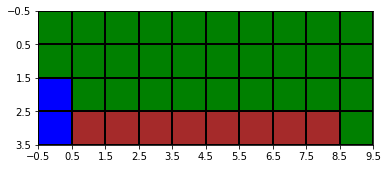

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

# create discrete colormap
cmap = colors.ListedColormap(['green', 'brown','blue'])
bounds = [-0.5,0.5,1.5,2.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(test_task.grid, cmap=cmap, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 10, 1));
ax.set_yticks(np.arange(-0.5, 4, 1));

plt.show()


In [558]:
test_task = CliffJump(num_rows=4, num_cols=10)